In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# matplotlib日本語対応
import matplotlib
matplotlib.rc('font', family='BIZ UDGothic')

import pandas_profiling as pdp

## Read Data

### train.csv
|特徴量|内容|例|
|:---:|:---|:---:|
|kind|野菜の種類|だいこん、かぶ、にんじん|
|date|日付|20051107|
|amount|卸売数量合計（合計の意味は、複数産地のものがあればその合計をとっているの意味）||
|mode_price|卸売価格中央値（中央値の意味は、複数産地のものがあればその中央値をとっているの意味）<-最頻値の間違い？||
|area|産地。複数産地のものが売られていた場合は"_"で結合||

- area:各地は「特定できない産地」という意味。「千葉_青森_各地」となっている場合の「各地」は、「千葉でも青森でもないエリア(特定できない)」の意味。

### wather.csv
|特徴量|内容|例|
|:---:|:---|:---:|
|date|日付||
|mean_temp|平均気温（℃）||
|max_temp|最高気温（℃）||
|max_temp_time|最高気温（℃）（時分）||
|min_temp|最低気温（℃）||
|min_temp_time|最低気温（℃）（時分）||
|sum_rain|降水量合計（mm）||
|sun_time|日照時間（時間）||
|mean_humid|平均湿度（%）||
|area|エリア||

In [2]:
# 野菜データ
vege_df = pd.read_csv('train.csv')

# 天気データ
weather_df = pd.read_csv('weather.csv')

# 野菜データ test
test_df = pd.read_csv('test.csv')

In [3]:
all_df = pd.concat([vege_df, test_df])

## データ確認：天気

In [4]:
weather_df.head(5)

,date,mean_temp,max_temp,max_temp_time,min_temp,min_temp_time,sum_rain,sun_time,mean_humid,area
0,20041106,13.1,20.1,2004/11/6 12:50,8.1,2004/11/6 05:31,5.0,1.6,77.0,青森
1,20041107,9.6,12.5,2004/11/7 13:40,5.4,2004/11/7 22:17,0.0,4.1,63.0,青森
2,20041108,9.0,15.5,2004/11/8 12:51,3.2,2004/11/8 06:28,0.0,8.9,72.0,青森
3,20041109,12.2,17.7,2004/11/9 14:40,5.7,2004/11/9 02:49,1.5,1.2,85.0,青森
4,20041110,11.6,16.4,2004/11/10 14:42,6.9,2004/11/10 06:23,0.0,7.5,89.0,青森


In [5]:
# 日付、温度観測時点を年月日のdatetimeに変換
weather_df['date'] = pd.to_datetime(weather_df['date'], format="%Y%m%d")
weather_df['max_temp_time'] = pd.to_datetime(weather_df['max_temp_time'].str[:-5])
weather_df['min_temp_time'] = pd.to_datetime(weather_df['min_temp_time'].str[:-5])

In [6]:
print("温度観測時点と日付に乖離があるか確認:",(weather_df['date'] - weather_df['max_temp_time']).astype('str').str[:-5].unique())
# display(weather_df[(weather_df['date'] - weather_df['max_temp_time']).astype('str').str[:-5] == ""])

print("温度観測時点と日付に乖離があるか確認:",(weather_df['date'] - weather_df['min_temp_time']).astype('str').str[:-5].unique())
# display(weather_df[(weather_df['date'] - weather_df['min_temp_time']).astype('str').str[:-5] == ""])

温度観測時点と日付に乖離があるか確認: ['0' '-1' '']
温度観測時点と日付に乖離があるか確認: ['0' '-1' '']


In [7]:
# 時点を削除
weather_df.drop(["max_temp_time", "min_temp_time"], axis=1, inplace=True)

In [8]:
# 全国平均を作成
weather_all = weather_df.groupby('date').agg('mean').reset_index()
weather_all['area'] = "全国"
weather_all

,date,mean_temp,max_temp,min_temp,sum_rain,sun_time,mean_humid,area
0,2004-11-06,15.525000,20.903125,11.409375,0.437500,6.915625,71.81250,全国
1,2004-11-07,15.337500,20.575000,10.506250,0.000000,8.134375,68.40625,全国
2,2004-11-08,15.018750,20.215625,10.378125,0.015625,6.325000,70.43750,全国
3,2004-11-09,15.687500,21.812500,10.881250,0.234375,7.746875,71.56250,全国
4,2004-11-10,16.478125,21.715625,11.400000,5.453125,5.709375,71.28125,全国
...,...,...,...,...,...,...,...,...
6380,2022-04-26,20.146875,23.943750,16.743750,19.718750,0.546875,85.00000,全国
6381,2022-04-27,19.634375,24.268750,15.193750,5.406250,3.331250,77.21875,全国
6382,2022-04-28,16.965625,21.950000,12.609375,0.062500,7.793750,61.93750,全国
6383,2022-04-29,13.887500,18.603125,9.593750,28.453125,1.031250,78.15625,全国


In [9]:
# 全国平均を統合
weather_df = weather_df.append(weather_all)

In [10]:
area_pairs = vege_df['area'].unique()

yasai_areas = set()

for area_pair in area_pairs:
    areas = area_pair.split('_')
    yasai_areas |= set(areas)

yasai_areas

{'アメリカ',
 'カナダ',
 'トンガ',
 'ニュージーランド',
 'メキシコ',
 '中国',
 '佐賀',
 '兵庫',
 '北海道',
 '千葉',
 '各地',
 '和歌山',
 '埼玉',
 '宮城',
 '宮崎',
 '山形',
 '山梨',
 '岩手',
 '徳島',
 '愛媛',
 '愛知',
 '新潟',
 '東京',
 '栃木',
 '沖縄',
 '熊本',
 '神奈川',
 '福岡',
 '福島',
 '秋田',
 '群馬',
 '茨城',
 '長崎',
 '長野',
 '青森',
 '静岡',
 '香川',
 '高知',
 '鹿児島'}

In [11]:
weather_areas = weather_df['area'].unique()

In [12]:
# エリア返還のmap作成
area_map = {}

update_area_map = {
    '岩手':'盛岡','宮城':'仙台','静岡':'浜松','沖縄':'那覇','神奈川':'横浜','愛知':'名古屋','茨城':'水戸','北海道':'帯広','各地':'全国',
    '兵庫':'神戸','香川':'高松','埼玉':'熊谷','国内':'全国','山梨':'甲府','栃木':'宇都宮','群馬':'前橋','愛媛':'松山'
}

for yasai_area in yasai_areas:
    if yasai_area not in weather_areas and yasai_area not in update_area_map:
        area_map[yasai_area] = '全国' # 外国の天候は全国にしておく
    else:
        area_map[yasai_area] = yasai_area

area_map = {**area_map, **update_area_map}
area_map

{'メキシコ': '全国',
 '和歌山': '和歌山',
 '福岡': '福岡',
 '香川': '高松',
 '愛知': '名古屋',
 '山形': '山形',
 '徳島': '徳島',
 '長崎': '長崎',
 '長野': '長野',
 '中国': '全国',
 '千葉': '千葉',
 '青森': '青森',
 'トンガ': '全国',
 '埼玉': '熊谷',
 '沖縄': '那覇',
 '栃木': '宇都宮',
 '山梨': '甲府',
 '神奈川': '横浜',
 'ニュージーランド': '全国',
 '各地': '全国',
 'カナダ': '全国',
 '北海道': '帯広',
 '兵庫': '神戸',
 '熊本': '熊本',
 '宮城': '仙台',
 'アメリカ': '全国',
 '茨城': '水戸',
 '高知': '高知',
 '東京': '東京',
 '秋田': '秋田',
 '愛媛': '松山',
 '鹿児島': '鹿児島',
 '群馬': '前橋',
 '新潟': '新潟',
 '静岡': '浜松',
 '佐賀': '佐賀',
 '宮崎': '宮崎',
 '福島': '福島',
 '岩手': '盛岡',
 '国内': '全国'}

In [13]:
weather_df

,date,mean_temp,max_temp,min_temp,sum_rain,sun_time,mean_humid,area
0,2004-11-06,13.100000,20.100000,8.100000,5.000000,1.600000,77.00000,青森
1,2004-11-07,9.600000,12.500000,5.400000,0.000000,4.100000,63.00000,青森
2,2004-11-08,9.000000,15.500000,3.200000,0.000000,8.900000,72.00000,青森
3,2004-11-09,12.200000,17.700000,5.700000,1.500000,1.200000,85.00000,青森
4,2004-11-10,11.600000,16.400000,6.900000,0.000000,7.500000,89.00000,青森
...,...,...,...,...,...,...,...,...
6380,2022-04-26,20.146875,23.943750,16.743750,19.718750,0.546875,85.00000,全国
6381,2022-04-27,19.634375,24.268750,15.193750,5.406250,3.331250,77.21875,全国
6382,2022-04-28,16.965625,21.950000,12.609375,0.062500,7.793750,61.93750,全国
6383,2022-04-29,13.887500,18.603125,9.593750,28.453125,1.031250,78.15625,全国


「各地」「アメリカ」などを「全国」に変換　←精緻化余地あり！！！！

In [14]:
vege_df['area'] = vege_df['area'].apply(lambda x: '_'.join([area_map[i] for i in x.split('_')]))
vege_df

,kind,date,amount,mode_price,area
0,だいこん,20051107,201445,735.0,千葉
1,だいこん,20051108,189660,840.0,千葉_全国_青森
2,だいこん,20051110,218166,735.0,千葉_全国_青森
3,だいこん,20051111,182624,682.5,千葉_青森
4,だいこん,20051112,220691,682.5,千葉_青森
...,...,...,...,...,...
97777,しめじ,20170526,17231,48.5,新潟_長野
97778,しめじ,20170527,17105,48.5,新潟_長野
97779,しめじ,20170529,12406,48.5,新潟_長野
97780,しめじ,20170530,12320,48.5,新潟_長野


天候データのエリアを「千葉_全国_青森」のように複数エリアにまたがっている場合の各統計量について、各エリアの平均をとることにする

In [56]:
# 卸売りデータのエリアのユニークリストを格納
area_pairs = vege_df['area'].unique()

target_cols = [i for i in weather_df.columns if i != 'area']
target_cols_ex_date = [i for i in target_cols if i != 'date']

area_pair_dfs = []

for area_pair in area_pairs:
    areas = area_pair.split('_')
    if len(areas) > 0:
        area = areas[0]
        base_tmp_df = weather_df[weather_df['area'] == area]
        base_tmp_df = base_tmp_df[target_cols].reset_index(drop=True)
        for area in areas[1:]:
            tmp_df = weather_df[weather_df['area'] == area]
            tmp_df = tmp_df[target_cols].reset_index(drop=True)
            base_tmp_df[target_cols_ex_date] = base_tmp_df[target_cols_ex_date].add(tmp_df[target_cols_ex_date])
        base_tmp_df[target_cols_ex_date] /= len(areas)
        base_tmp_df['area'] = area_pair
        area_pair_dfs.append(base_tmp_df)

area_pair_df = pd.concat(area_pair_dfs)
print(area_pair_df.shape)
area_pair_df.head()

(1545170, 8)


,date,mean_temp,max_temp,min_temp,sum_rain,sun_time,mean_humid,area
0,2004-11-06,17.4,21.2,14.1,0.0,5.1,84.0,千葉
1,2004-11-07,17.0,22.2,13.5,0.0,7.9,77.0,千葉
2,2004-11-08,15.8,19.0,12.7,0.0,0.6,72.0,千葉
3,2004-11-09,16.8,21.5,12.4,0.0,7.8,75.0,千葉
4,2004-11-10,16.7,21.9,11.5,0.0,6.7,79.0,千葉


In [59]:
weather_df.shape

(210705, 8)

## データ確認

In [3]:
print("(行,列) = ", vege_df.shape)
print(vege_df.describe())
display(vege_df.head(5))


(行,列) =  (97782, 5)
               date         amount    mode_price
count  9.778200e+04   97782.000000  97782.000000
mean   2.013619e+07   87095.257246   1341.207081
std    4.726274e+04   84438.195701   1304.031597
min    2.005111e+07       1.000000     18.500000
25%    2.009123e+07   21664.250000    227.000000
50%    2.014012e+07   58335.500000   1242.000000
75%    2.018020e+07  128100.750000   1890.000000
max    2.022043e+07  965216.000000  25920.000000


,kind,date,amount,mode_price,area
0,だいこん,20051107,201445,735.0,千葉
1,だいこん,20051108,189660,840.0,千葉_各地_青森
2,だいこん,20051110,218166,735.0,千葉_各地_青森
3,だいこん,20051111,182624,682.5,千葉_青森
4,だいこん,20051112,220691,682.5,千葉_青森


## EDA(探索的データ分析)

In [4]:
# pandas-profilingでデータの外観を確認
report = pdp.ProfileReport(vege_df)
report.to_file('Pandas-profiling_report.html')

Summarize dataset:   0%|          | 0/18 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
print(vege_df.date.min())
print(vege_df.date.max())

20051107
20220430


['だいこん' 'かぶ' 'にんじん' 'ごぼう' 'れんこん' 'キャベツ' 'レタス' 'はくさい' 'こまつな' 'ほうれんそう' 'ねぎ'
 'しゅんぎく' 'ブロッコリー' 'きゅうり' 'かぼちゃ' 'なす' 'トマト' 'ピーマン' 'じゃがいも' 'さつまいも' 'さといも'
 'たまねぎ' 'なましいたけ' 'セルリー' 'さやえんどう' 'なのはな' 'たけのこ' 'ふき' 'うど' 'そらまめ' 'アスパラガス'
 'ピース' 'とうもろこし' 'いんげん' 'えだまめ' 'うめ' 'まつたけ' 'オクラ' 'レイシにがうり' 'みずな' 'ミニトマト'
 'にら' 'えのきだけ' 'しめじ']


<AxesSubplot:>

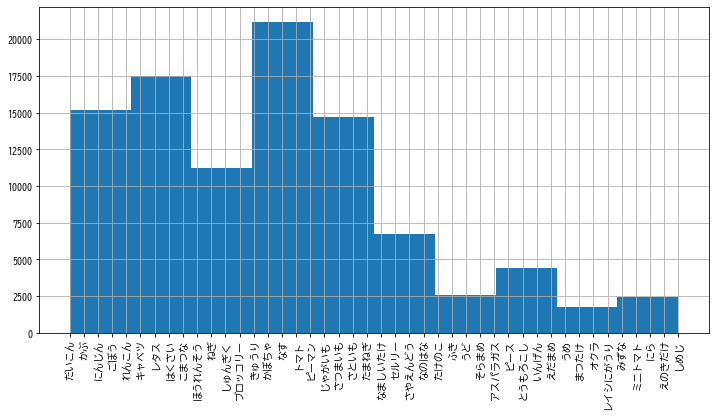

In [13]:
print(vege_df.kind.unique())
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
vege_df.kind.hist()

['千葉' '千葉_各地_青森' '千葉_青森' '千葉_各地' '千葉_神奈川' '千葉_各地_神奈川' '神奈川' '千葉_各地_茨城'
 '千葉_茨城' '青森' '北海道_青森' '北海道_各地_青森' '北海道_各地' '北海道_千葉_各地' '各地_神奈川' '各地_青森'
 '各地' '北海道' '千葉_埼玉' '千葉_各地_埼玉' '各地_埼玉' '埼玉' '北海道_千葉' '千葉_徳島' '千葉_各地_徳島'
 '徳島' '各地_徳島' '中国_各地_徳島' '中国_北海道' '各地_徳島_静岡' '徳島_静岡' '茨城' '各地_茨城'
 '各地_茨城_青森' '茨城_青森' '佐賀_茨城' '佐賀_各地_茨城' '千葉_各地_愛知' '千葉_愛知' '愛知' '各地_愛知_神奈川'
 '岩手_群馬' '各地_岩手_群馬' '北海道_各地_群馬' '各地_群馬' '群馬' '千葉_各地_群馬' '千葉_群馬' '各地_愛知'
 '愛知_神奈川' '各地_群馬_茨城' '各地_茨城_香川' '各地_静岡_香川' '各地_香川' '各地_茨城_長野' '茨城_長野' '長野'
 '群馬_長野' '各地_群馬_長野' '各地_長野' '静岡_香川' '各地_茨城_静岡' '兵庫_各地_茨城' '兵庫_各地_静岡'
 '各地_静岡' '兵庫_茨城' '兵庫_各地' '兵庫_静岡' '茨城_静岡' '静岡' '各地_茨城_長崎' '群馬_茨城' '埼玉_東京'
 '各地_埼玉_東京' '各地_東京' '東京' '各地_埼玉_群馬' '埼玉_群馬' '各地_栃木' '栃木_群馬' '栃木' '栃木_茨城'
 '各地_栃木_群馬' '中国_各地_青森' '各地_埼玉_青森' '埼玉_青森' '各地_秋田_青森' '秋田_青森' '各地_秋田'
 '千葉_栃木' '千葉_各地_栃木' '各地_埼玉_愛知' '埼玉_愛知' '香川' '福島_長野' '千葉_各地_宮崎' '各地_埼玉_福島'
 '各地_岩手_福島' '各地_福島' '各地_埼玉_宮崎' '各地_福島_茨城' '岩手' '各地_宮崎_高知' '各地_宮崎_群馬'
 '各地_福島_群馬' 'トンガ_北海道' 'トンガ' 'トンガ_北海道_各地' 'トンガ_メキシコ_各地' 'トンガ_各地' 'トンガ_

<AxesSubplot:>

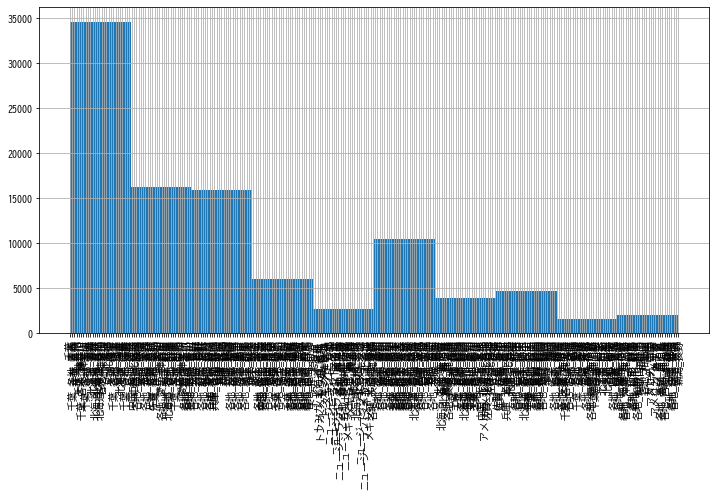

In [40]:
print(vege_df.area.unique())
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
vege_df.area.hist()

In [39]:
pd.to_datetime(vege_df.date, format="%Y%m%d")


# リストを結合する関数 例：['2005', '11', '07'] -> '20051107'
list_join_function = lambda x: "".join(x)
# datetimeをstr型にし、-で分割したのち結合 例: 2005-11-07 -> '20051107'
pd.to_datetime(vege_df.date, format="%Y%m%d").astype('str').str.split('-').apply(list_join_function)

0        20051107
1        20051108
2        20051110
3        20051111
4        20051112
           ...   
97777    20170526
97778    20170527
97779    20170529
97780    20170530
97781    20170531
Name: date, Length: 97782, dtype: object

欠損値の処理の仕方
- データが非常多ければ削除
- 大体は欠損値保管
    - 回帰